In [ ]:
# main libraries
import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# graphical libraries
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image as mg
import cv2

# data science & deep learning libraries
import numpy as np
import tensorflow as tf



In [ ]:
# constants
TRAIN_SIZE = 1000
TEST_SIZE = 650
WILD_PATH = 'wild'
IMAGE_SIZE = 128

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Getting Images

In [ ]:

images = os.listdir('/content/drive/MyDrive/imgs')
train_dir='/content/drive/MyDrive/imgs'

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,validation_split=0.3,subset="training",seed=123,image_size=(IMAGE_SIZE, IMAGE_SIZE),)
val_ds = tf.keras.utils.image_dataset_from_directory(train_dir,validation_split=0.3,subset="validation",seed=123,image_size=(IMAGE_SIZE, IMAGE_SIZE),)
train_ds = train_ds.unbatch()
val_ds = val_ds.unbatch()
train_xs = []
test_xs = []
for x,y in train_ds:
    train_xs.append(x.astype('float32')/255.)
for x,y in val_ds:
    test_xs.append(x.astype('float32')/255.)
train_xs = tf.convert_to_tensor(train_xs)
test_xs = tf.convert_to_tensor(test_xs)

Found 4772 files belonging to 1 classes.
Using 3341 files for training.
Found 4772 files belonging to 1 classes.
Using 1431 files for validation.


In [ ]:
train_xs.shape

TensorShape([3341, 128, 128, 3])

### Show Random Train Image:

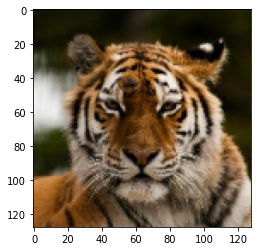

In [ ]:
random_image_index = np.random.randint(0, TRAIN_SIZE)
random_image = train_xs[random_image_index]
plt.imshow(random_image)

### Convolutional Layers:

In [ ]:
from tensorflow.keras.models import Model

encoder_in = tf.keras.Input(shape=(128,128,3),name='img_input')
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Flatten()(layer)
encoder_out = tf.keras.layers.Dense(1024,activation='relu')(layer)
       
decoder_in = tf.keras.layers.Dense(2048,activation='relu')(encoder_out)
layer = tf.keras.layers.Reshape((8,8,32))(decoder_in)
layer = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.UpSampling2D((2,2))(layer)
layer = layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.UpSampling2D((2,2))(layer)
layer = layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.UpSampling2D((2,2))(layer)
layer = tf.keras.layers.UpSampling2D((2,2))(layer)
decoder_out = tf.keras.layers.Conv2D(3,(3,3),activation='relu',padding='same')(layer)

          
autoencode = tf.keras.Model(encoder_in,decoder_out,name='an_dec')
autoencode.summary()
      

Model: "an_dec"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0    

In [ ]:

optimizer = tf.keras.optimizers.Adam(lr = 0.001,decay=1e-6)
autoencode.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())



In [ ]:

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

autoencode.fit(train_xs, train_xs,
                epochs=50,
                shuffle=True,
                batch_size=30)


Epoch 1/50
112/112 [==============================] - 11s 98ms/step - loss: 0.0234
Epoch 2/50
112/112 [==============================] - 11s 97ms/step - loss: 0.0217
Epoch 3/50
112/112 [==============================] - 11s 97ms/step - loss: 0.0206
Epoch 4/50
112/112 [==============================] - 11s 98ms/step - loss: 0.0197
Epoch 5/50
112/112 [==============================] - 11s 97ms/step - loss: 0.0192
Epoch 6/50
112/112 [==============================] - 11s 97ms/step - loss: 0.0186
Epoch 7/50
112/112 [==============================] - 11s 97ms/step - loss: 0.0186
Epoch 8/50
112/112 [==============================] - 11s 97ms/step - loss: 0.0180
Epoch 9/50
112/112 [==============================] - 11s 97ms/step - loss: 0.0175
Epoch 10/50
112/112 [==============================] - 11s 97ms/step - loss: 0.0173
Epoch 11/50
112/112 [==============================] - 11s 96ms/step - loss: 0.0173
Epoch 12/50
112/112 [==============================] - 11s 97ms/step - loss: 0.0171
E

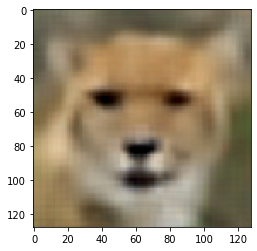

In [ ]:



ry = autoencode.predict(test_xs[524].reshape(-1,128,128,3))
ry[0][0][1]
plt.imshow(ry.reshape(128,128,3),cmap='gray')



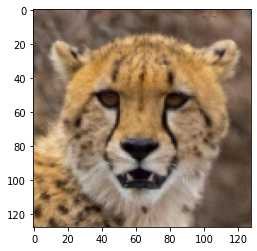

In [ ]:
plt.imshow(test_xs[524])
# plt.imshow(train_xs[1]*255)

In [ ]:
#generating masks
left = 60
right = 76
up = 78
down = 62
x_train = train_xs.numpy()
black_train = x_train.copy()
black_train[:,left:right,down:up,:] = 0
train_labels = x_train[:,left:right,down:up,:]
x_test = test_xs.numpy()
black_test = x_test.copy()
black_test[:,left:right,down:up,:] = 0
test_labels = x_test[:,left:right,down:up,:]

In [ ]:
from tensorflow.keras.models import Model

encoder_in = tf.keras.Input(shape=(128,128,3),name='img_input')
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Flatten()(layer)
encoder_out = tf.keras.layers.Dense(1024,activation='relu')(layer)
       
decoder_in = tf.keras.layers.Dense(2048,activation='relu')(encoder_out)
layer = tf.keras.layers.Reshape((8,8,32))(decoder_in)
layer = tf.keras.layers.Conv2D(3,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.UpSampling2D((2,2))(layer)
layer = layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(layer)

 ## for making the hole bigger to 32 pixels
# layer = tf.keras.layers.UpSampling2D((2,2))(layer)

# layer = layer = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(layer)

decoder_out = tf.keras.layers.Conv2D(3,(3,3),activation='relu',padding='same')(layer)

          
autoencoder = tf.keras.Model(encoder_in,decoder_out,name='an_dec')
autoencoder.summary()
      

Model: "an_dec"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_31 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0    

In [ ]:

optimizer = tf.keras.optimizers.Adam(lr = 0.001,decay=1e-6)
autoencoder.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

In [ ]:

print(black_test.shape)
print(test_labels.shape)

(1431, 128, 128, 3)
(1431, 16, 16, 3)


In [ ]:
history = autoencoder.fit(black_train,train_labels ,
                epochs=20,
                shuffle=True,
                batch_size=30,
                validation_data=(black_test,test_labels))

Epoch 1/20
112/112 [==============================] - 8s 63ms/step - loss: 0.0616 - val_loss: 0.0294
Epoch 2/20
112/112 [==============================] - 7s 59ms/step - loss: 0.0253 - val_loss: 0.0236
Epoch 3/20
112/112 [==============================] - 7s 60ms/step - loss: 0.0200 - val_loss: 0.0201
Epoch 4/20
112/112 [==============================] - 7s 59ms/step - loss: 0.0172 - val_loss: 0.0190
Epoch 5/20
112/112 [==============================] - 7s 60ms/step - loss: 0.0153 - val_loss: 0.0187
Epoch 6/20
112/112 [==============================] - 7s 60ms/step - loss: 0.0139 - val_loss: 0.0181
Epoch 7/20
112/112 [==============================] - 7s 60ms/step - loss: 0.0128 - val_loss: 0.0182
Epoch 8/20
112/112 [==============================] - 7s 60ms/step - loss: 0.0117 - val_loss: 0.0175
Epoch 9/20
112/112 [==============================] - 7s 60ms/step - loss: 0.0106 - val_loss: 0.0174
Epoch 10/20
112/112 [==============================] - 7s 59ms/step - loss: 0.0095 - val_lo

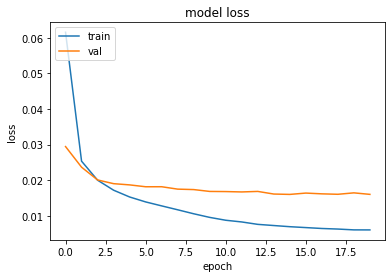

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'input')

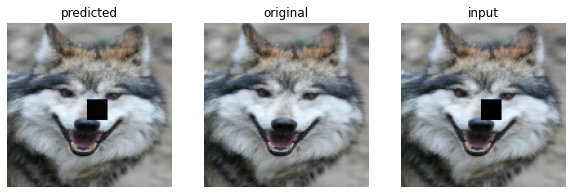

In [ ]:
index = 92
ry = autoencoder.predict(black_test[index].reshape(-1,128,128,3))
pic = black_test[index].copy()
pic[left:right,down:up] = ry
rows = 1
colls = 3
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows,colls,1)
plt.imshow(pic)
plt.axis('off')
plt.title("predicted")
fig.add_subplot(rows,colls,2)
plt.imshow(test_xs[index])
plt.axis('off')
plt.title("original")
fig.add_subplot(rows,colls,3)
plt.imshow(black_test[index])
plt.axis('off')
plt.title("input")